/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 Training Accuracy: 95.18%

 Best Threshold: 0.280
 Accuracy: 80.61%
 Precision: 0.443
 Recall: 0.830
 F1-score: 0.578

 Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.80      0.87       247
           1       0.44      0.83      0.58        47

    accuracy                           0.81       294
   macro avg       0.70      0.82      0.73       294
weighted avg       0.88      0.81      0.83       294



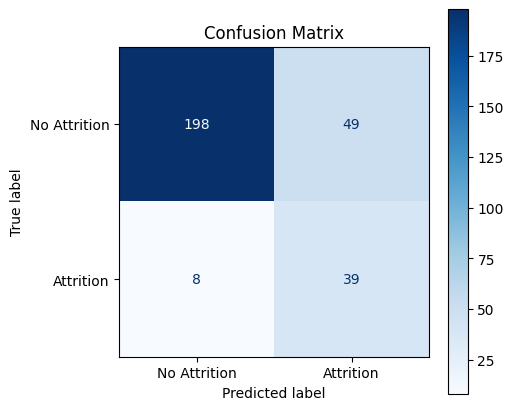

In [3]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import (
    accuracy_score, classification_report,
    precision_score, recall_score, f1_score
)
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Load and clean data
df=pd.read_csv("/content/sample_data/ATTRITION DATASET.csv")
df.dropna(inplace=True)

# 2. Drop non-informative columns
df.drop(columns=['EmployeeCount', 'Over18', 'StandardHours', 'MonthlyIncome'], inplace=True)

# 3. Encode categorical features
y = df["Attrition"].map({'Yes': 1, 'No': 0})
X = df.drop("Attrition", axis=1)

le = LabelEncoder()
for col in X.select_dtypes(include='object').columns:
    X[col] = le.fit_transform(X[col])

# 4. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 5. Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6. SMOTE for class imbalance
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# 7. Define base learners
base_learners = [
    ('rf', RandomForestClassifier(
        n_estimators=120, max_depth=5, min_samples_split=10, min_samples_leaf=5,
        max_features='sqrt', bootstrap=True, class_weight='balanced_subsample', random_state=42
    )),
    ('xgb', XGBClassifier(
        use_label_encoder=False, eval_metric='logloss', n_estimators=100,
        learning_rate=0.03, max_depth=3, subsample=0.6, colsample_bytree=0.6,
        scale_pos_weight=2, reg_lambda=10.0, reg_alpha=2.0, gamma=10.0, random_state=42
    )),
    ('lgb', LGBMClassifier(
        n_estimators=100, learning_rate=0.05, max_depth=5, subsample=0.7,
        colsample_bytree=0.7, class_weight='balanced', reg_lambda=5.0,
        reg_alpha=1.0, random_state=42
    ))
]

# 8. Define meta-learner
meta_learner = ExtraTreesClassifier(
    n_estimators=100, max_depth=6, min_samples_split=10,
    min_samples_leaf=5, max_features='sqrt', class_weight='balanced',
    random_state=42, n_jobs=-1
)

# 9. Define and train stacking model
stacking_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    passthrough=True,
    cv=5,
    n_jobs=-1
)

stacking_model.fit(X_train_balanced, y_train_balanced)

# 🔍 Training Accuracy
y_train_pred = stacking_model.predict(X_train_balanced)
train_acc = accuracy_score(y_train_balanced, y_train_pred)
print(f"\n Training Accuracy: {train_acc * 100:.2f}%")

# 10. Evaluate
y_proba = stacking_model.predict_proba(X_test_scaled)[:, 1]

# Threshold tuning
thresholds = np.linspace(0.1, 0.9, 81)
best_f1 = 0
best_thresh = 0
for thresh in thresholds:
    y_pred = (y_proba >= thresh).astype(int)
    f1 = f1_score(y_test, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = thresh

# Final predictions
y_final = (y_proba >= best_thresh).astype(int)

# Report
print(f"\n Best Threshold: {best_thresh:.3f}")
print(f" Accuracy: {accuracy_score(y_test, y_final) * 100:.2f}%")
print(f" Precision: {precision_score(y_test, y_final):.3f}")
print(f" Recall: {recall_score(y_test, y_final):.3f}")
print(f" F1-score: {f1_score(y_test, y_final):.3f}")
print("\n Classification Report:")
print(classification_report(y_test, y_final))
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_final)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Attrition', 'Attrition'])
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()
